<center><h1>Data Visualization of Crosswalk Assets</h1></center>

The Signs & Markings division is responsible for installation and maintenance of signs and street markings for the public in order to provide for the purpose of guiding, warning, or regulatory traffic by providing safe and efficient movement of goods and services.

Street markings include but are not limited to: lane lines, painted curbs, delineators, concrete domes, reflective road pavement markings, crosswalks, stop lines, yield lines, parking stall lines, arrows, bike symbols, and word markings. In addition, this division is responsible for producing and maintaining all street signs within the City of Austin’s full jurisdiction.

The purpose of this notebook is to visualize the markings assets represented by installation date and total pavement markings assets maintained within the City of Austin full jurisdiction.

Packages used for visualization include `arcgis`, `pandas`, and `seaborn`.

In [2]:
import datetime
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame

Data analysis of pavement markings are used for financial, performance measures, and maintenance goals.

In [3]:
class CreateSDF(SpatialDataFrame):
    _metadata = ['my_attr']
    
    @property
    def _constructor(self):
        return SpatialDataFrame
    
    def __init__(self, *args, **kwargs):
        self.my_attr = kwargs.pop('my_attr', None)
        super().__init__(*args, **kwargs)
    
    def agol(title):
        gis = GIS("https://austin.maps.arcgis.com/home/index.html",client_id='CrnxPfTcm7Y7ZGl7')
        print("successfully logged in as: " + gis.properties.user.username)
        search = gis.content.search(query="title:" + title,item_type="Feature Layer")
        item = search[0]
        layer = item.layers[0]
        sdf = SpatialDataFrame.from_layer(layer)
        return sdf

Here we create a spatial dataframe using the `arcgis` package from an existing feature layer dataset in ArcGIS Online called markings_short_line.

The dataset [markings_short_line](https://data.austintexas.gov/Transportation-and-Mobility/TRANSPORTATION-markings_short_line/3p2i-pqdc) can also be found in the Open Data Portal.

In [4]:
fields = ['SUBTYPE','BARS','CREW_ASSIGNED','INSTALL_DATE']
cols = ['Crosswalk', 'Total Continental Bars', 'Total', 'Date']
q = "INSTALL_DATE == INSTALL_DATE & SHORT_LINE_TYPE == 'CROSSWALK'"
fl = "markings_short_line"

sdf = CreateSDF.agol(fl).query(q).filter(items=fields).rename(columns=dict(zip(fields,cols)))

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://austin.maps.arcgis.com/sharing/rest/oauth2/authorize?expiration=-1&client_id=CrnxPfTcm7Y7ZGl7&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code
Enter code obtained on signing in using SAML: ········
successfully logged in as: Susanne.Gov@austintexas.gov_austin


In [5]:
col_names = ['Year','Month','Crosswalk']
stat = {'Total Continental Bars':'sum','Total':'count'}
group = [sdf['Date'].dt.year.rename('Year'),sdf['Date'].dt.month.rename('Month'),"Crosswalk"]
q = "Year == 2018 & Crosswalk == 'Continental'"

x_walk = sdf.groupby(group,observed = False).agg(stat).query('Year > 2015')
for x in range(len(col_names)):
    x_walk[col_names[x]] = x_walk.index.values
    x_walk[col_names[x]] = x_walk[col_names[x]].apply(lambda y: y[:][x])
x_walk['Date'] = pd.to_datetime(x_walk.Year.apply(str) + '/' + x_walk.Month.apply(str),
                                format = "%Y/%m")
x_walk['Crosswalk'] = x_walk['Crosswalk'].apply(lambda x: x.lower().capitalize())
x_walk.reset_index(drop=True,inplace=True)
display(x_walk.filter(items=['Crosswalk','Month','Year','Total']).query(q))

,Crosswalk,Month,Year,Total
46,Continental,1,2018,44
48,Continental,2,2018,44
50,Continental,3,2018,19
52,Continental,4,2018,54
54,Continental,5,2018,40
56,Continental,6,2018,105
58,Continental,7,2018,87
60,Continental,8,2018,122
62,Continental,9,2018,30
64,Continental,10,2018,17


After the spatial dataframe has been created, a dataframe is created to show the total number of crosswalks installed based on crosswalk type, month, and year. The table above shows the total number of continental crosswalks installed for 2018.

Next task is to visualize the total installations of crosswalks done in the City of Austin. The graph below shows how many crosswalks were installed/maintained by date and crosswalk type using `seaborn`.

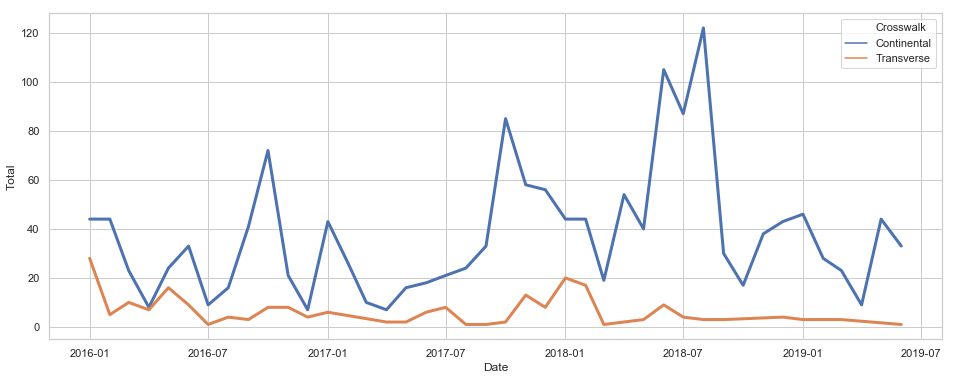

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="Date", y="Total",hue="Crosswalk",linewidth=3, data=x_walk)

Generally, crosswalk maintenace and installations peaks around summer-fall season. Good weather condition ensure that the crosswalk lasts in good condition.

We can look on the crosswalks installed based on month and year to see if there is a correlation with seasonal-yearly installation.

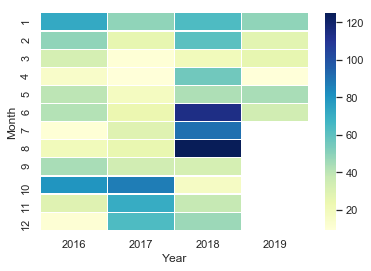

In [7]:
corr_sdf = x_walk.pivot_table(values='Total',index='Month',columns='Year',aggfunc=np.sum)
display(sns.heatmap(corr_sdf,annot=False,fmt=".2f",linewidths=.2,cmap="YlGnBu"))

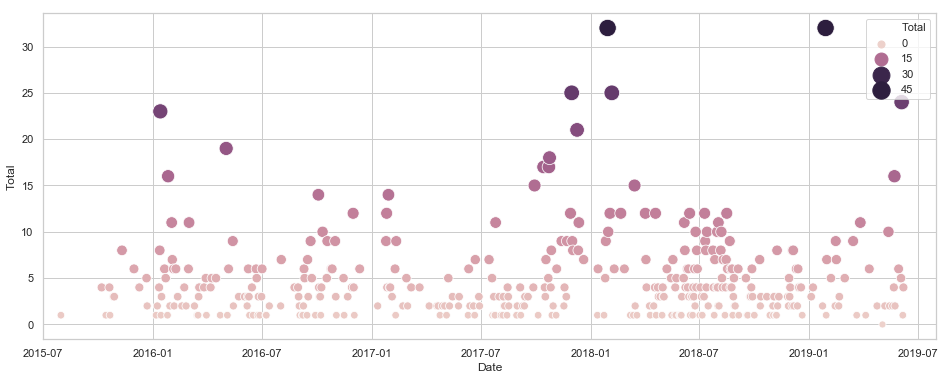

In [8]:
counts_sdf = sdf.groupby(['Date']).agg(stat)
counts_sdf['Date'] = counts_sdf.index
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="Date", y="Total",hue = 'Total',size='Total',data=counts_sdf,sizes=(50,300))
x_axis = ax.set(xlim = ('2015-07-01', '2019-07-31'))